In [30]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt


import warnings
warnings.filterwarnings("ignore")

In [31]:
df = pd.read_csv("/kaggle/input/sms-spam-collection-dataset/spam.csv", encoding='latin1')

In [32]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5572 entries, 0 to 5571
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   v1          5572 non-null   object
 1   v2          5572 non-null   object
 2   Unnamed: 2  50 non-null     object
 3   Unnamed: 3  12 non-null     object
 4   Unnamed: 4  6 non-null      object
dtypes: object(5)
memory usage: 217.8+ KB


## Data Cleaning

In [34]:
df.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [35]:
# I'm gonna remove 3 coluumns which is almost null and not import at all

df.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace=True)

In [37]:
# renaming the columns 

df.rename(columns = {'v1': 'target',
                    'v2': 'message'}, inplace=True)

In [38]:
df.isnull().sum()

target     0
message    0
dtype: int64

In [39]:
# Checking for duplicates values
df.duplicated().sum()

403

In [40]:
# Removing ducplicates
df = df.drop_duplicates()

In [41]:
df['message'][2]

"Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's"

# EDA

In [42]:
df['target'].value_counts()

target
ham     4516
spam     653
Name: count, dtype: int64

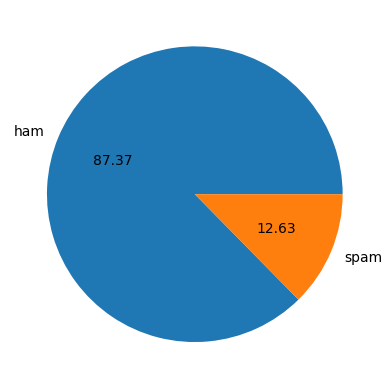

In [43]:
# The classification of ham and spam sms
import matplotlib.pyplot as plt

plt.pie(df['target'].value_counts(), labels = ['ham', 'spam'],autopct= '%0.2f')
plt.show()

In [44]:
# The number of caracter in each message
df['number_of_caracters'] = df['message'].apply(len)

In [45]:
# The number of words in each message
import nltk
df['number_of_words'] = df['message'].map(lambda x: len(nltk.word_tokenize(x)))

# Same for sentence
df['number_of_sentences'] = df['message'].map(lambda x: len(nltk.sent_tokenize(x)))

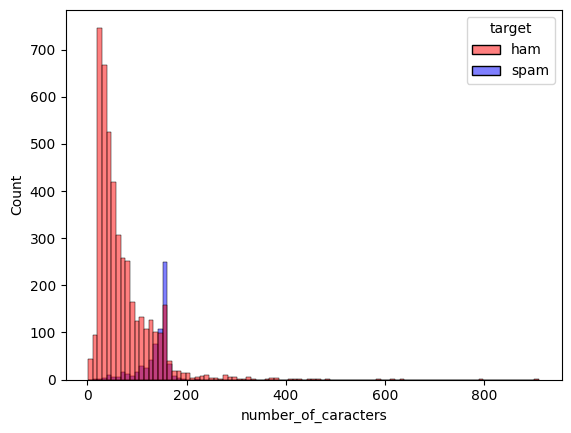

In [46]:
# The distribution of spam and ham caracters wise
sns.histplot(data=df, x='number_of_caracters', hue='target', palette={'spam': 'blue', 'ham': 'red'})
plt.show()

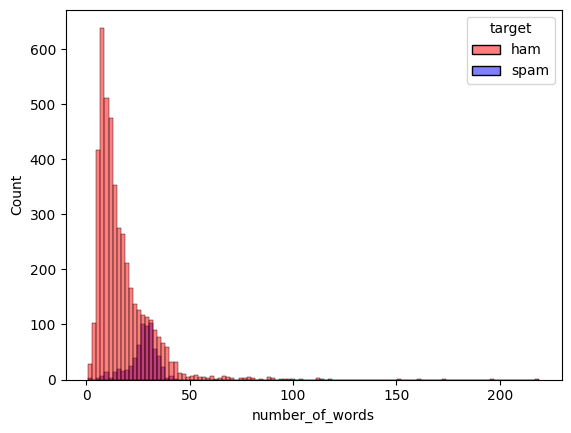

In [47]:
# The distribution of spam and ham words wise
sns.histplot(data=df, x='number_of_words', hue='target', palette={'spam': 'blue', 'ham': 'red'})
plt.show()

<Axes: xlabel='number_of_sentences', ylabel='count'>

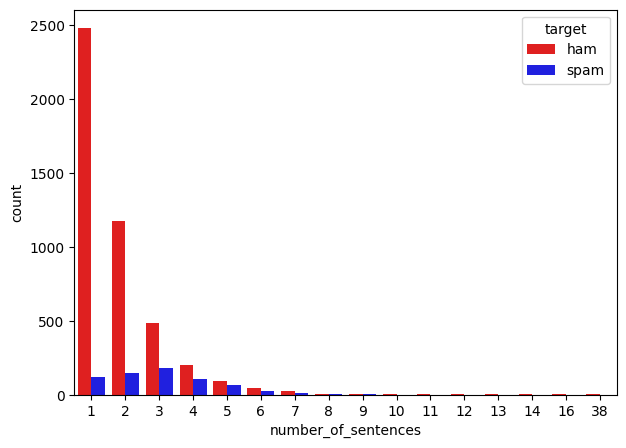

In [48]:
plt.figure(figsize=(7,5))
sns.countplot(data=df, x='number_of_sentences', hue='target', palette={'spam': 'blue', 'ham': 'red'})

In [49]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['target'] = le.fit_transform(df['target'])

<Axes: >

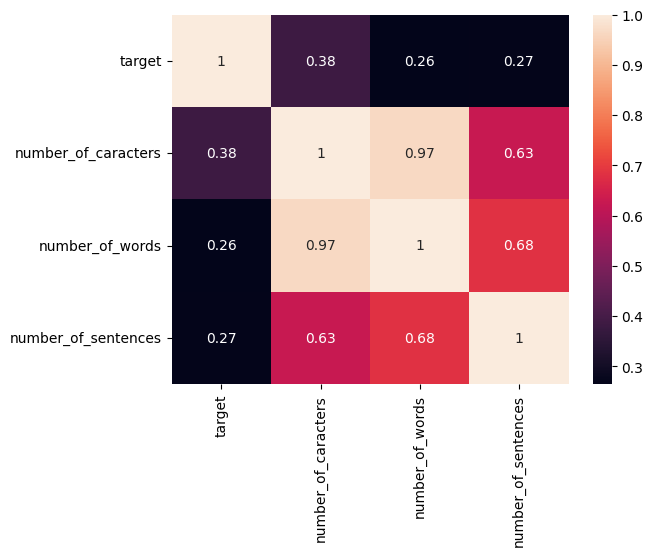

In [50]:
sns.heatmap(df.drop(columns = 'message').corr(), annot=True)

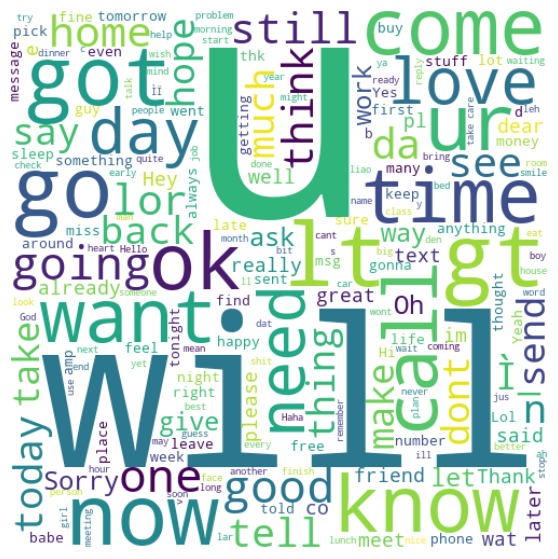

In [51]:
from wordcloud import WordCloud

# Generating the word cloud
wcloud = WordCloud(width=500, height=500, background_color='white')
text0 = df[df['target'] == 0]['message'].str.cat(sep="")
wcloud.generate(text0)

# Displaying the word cloud
plt.figure(figsize=(7, 7))
plt.imshow(wcloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

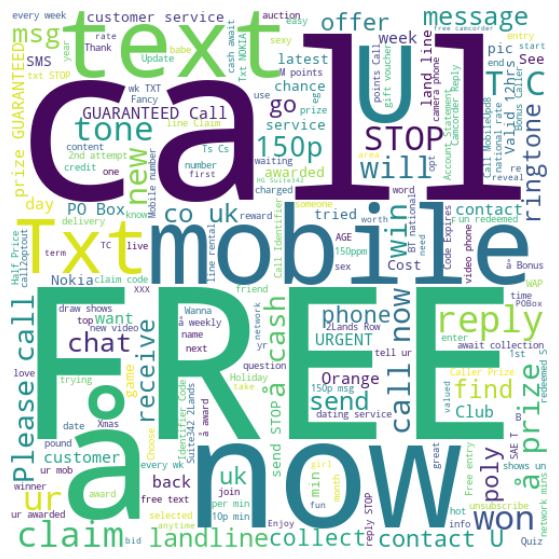

In [52]:
text1 = df[df['target'] == 1]['message'].str.cat(sep="")
text1cloud = wcloud.generate(text1)

# Displaying the word cloud
plt.figure(figsize=(10, 7))
plt.imshow(text1cloud, interpolation='bilinear')
plt.axis('off')  # Hide axes
plt.show()

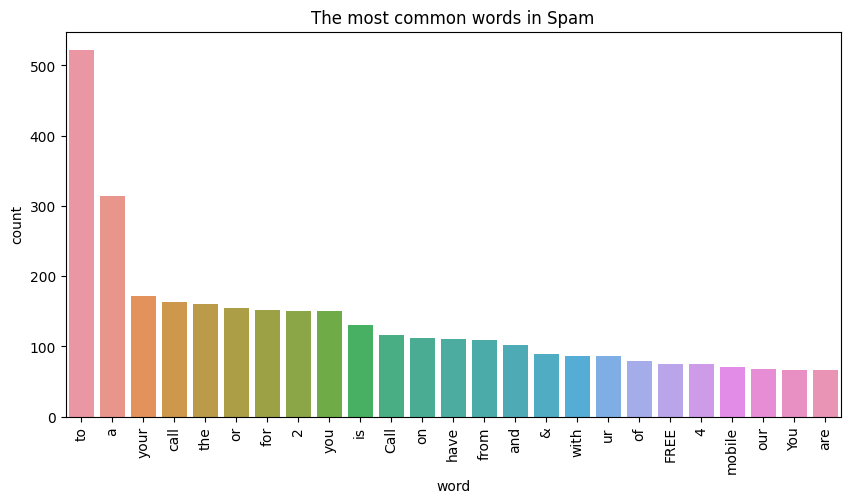

In [53]:
from collections import Counter

listof1 = df[df['target'] == 1]['message'].tolist()
wordcount1 = []
for row in listof1:
    for word in row.split():
        wordcount1.append(word)

wordcount1df = pd.DataFrame(Counter(wordcount1).most_common(25), columns=['word', 'count'])

plt.figure(figsize = (10, 5))
sns.barplot(x ='word', y='count', data =wordcount1df)
plt.title("The most common words in Spam")
plt.xticks(rotation='vertical')
plt.show()

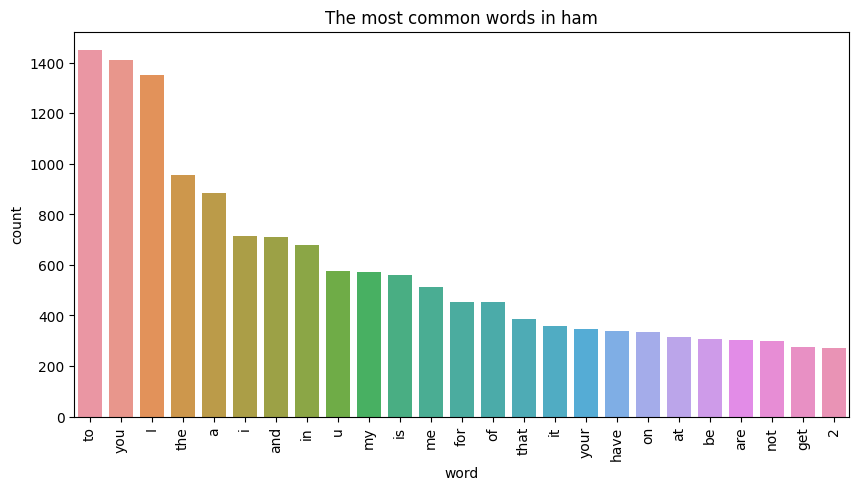

In [54]:
from collections import Counter
listof0 = df[df['target'] == 0]['message'].tolist()
wordcount0 = []
for row in listof0:
    for word in row.split():
        wordcount0.append(word)

wordcount0df = pd.DataFrame(Counter(wordcount0).most_common(25), columns=['word', 'count'])

plt.figure(figsize = (10, 5))
sns.barplot(x ='word', y='count', data =wordcount0df)
plt.title("The most common words in ham")
plt.xticks(rotation='vertical')
plt.show()

# Data Preprocessing

In [55]:
import nltk

In [56]:
def cleaning(data):

    # Change everything to lowercase
    data = data.lower()

    # tokenzer breaking down text into smaller, manageable pieces.
    newdata = nltk.word_tokenize(data)

    # this part will remove punctuation from the data
    list = []
    for i in newdata:
        if i.isalnum():
            list.append(i)

    return " ".join(list)

In [57]:
cleaning("FreeMsg Hey there darling it's 666   been 3 week's %$# now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, å£1.50 to rcv")

'freemsg hey there darling it 666 been 3 week now and no word back i like some fun you up for it still tb ok xxx std chgs to send to rcv'

In [58]:
# applying the cleaning function on message
df['modify_message'] = df['message'].apply(cleaning)

### Stopwords

In [59]:
# Removing stop words from the data 
from nltk.corpus import stopwords
sw = stopwords.words('english')

def stop_words(text):
    result = []
    for word in text.split():
        if word not in sw: # if word not in sw then append it to result mean only append 
            result.append(word)
    return result

In [60]:
stop_words('hi my name is khan afridi')

['hi', 'name', 'khan', 'afridi']

In [61]:
df['modify_message'] = df['modify_message'].apply(stop_words)

### Stemming

In [62]:
# This functiion will change every word to their root form like loved to love
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

def stemming(text):
    list = []

    # we are splitting each word in list and then we loop trough each words to apply stemming oon it 
    for i in text:
        stem = ps.stem(i)
        list.append(stem)
        
    # we are going to use join to remove the list from it 
    return " ".join(list)

In [63]:
df['modify_message'].apply(stemming)[:3]

0    go jurong point avail bugi n great world la e ...
1                                ok lar joke wif u oni
2    free entri 2 wkli comp win fa cup final tkt 21...
Name: modify_message, dtype: object

In [64]:
df['modify_message'] = df['modify_message'].apply(stemming)

# Model building

In [74]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

cv = CountVectorizer(max_features=2000, )
tfidf = TfidfVectorizer(max_features = 3000)

In [75]:
x = cv.fit_transform(df['modify_message']).toarray()
y = df['target']

In [79]:
x.shape

(5169, 2000)

In [76]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=20, random_state=41)

In [77]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB, BernoulliNB
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

# Defining Models
Models = {
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "MultinomialNB": MultinomialNB(),
    "GaussianNB": GaussianNB(),
    "BernoulliNB": BernoulliNB(),
    "Linear SVM": LinearSVC(),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=3),
}

# Train, Predict, and Evaluate
for i, model in Models.items():
    model.fit(x_train, y_train)
    y_pred = model.predict(x_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)
    cv_scores = cross_val_score(model,x, y, scoring='accuracy', cv= 5)
    
    print(f"{i} Accuracy Score: {accuracy}")
    print(f"Cross val Score: {np.mean(cv_scores)}")
    print(f"Classification Report: \n{report}")
    print("="*60)

Logistic Regression Accuracy Score: 0.95
Cross val Score: 0.9758169946878728
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.80      0.89         5

    accuracy                           0.95        20
   macro avg       0.97      0.90      0.93        20
weighted avg       0.95      0.95      0.95        20

Random Forest Accuracy Score: 0.95
Cross val Score: 0.9731075663641418
Classification Report: 
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        15
           1       1.00      0.80      0.89         5

    accuracy                           0.95        20
   macro avg       0.97      0.90      0.93        20
weighted avg       0.95      0.95      0.95        20

MultinomialNB Accuracy Score: 1.0
Cross val Score: 0.9783313142131703
Classification Report: 
              precision    recall  f1-score   support

 